# Setup

- ### Import Dependencies

In [4]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# %pip install opencv-python matplotlib


In [5]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

- ### Set GPU Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# Verify install:
import tensorflow as tf; 
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

tf.Tensor(-58.379044, shape=(), dtype=float32)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- ### Create Folder Structures

In [9]:
# Setup paths - joins repos 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## Collect Positives and Anchors

- ### untar labelled faces in the wild ds

In [ ]:
!tar -xf lfw.tgz

In [ ]:
#move lfw images to the negative repo
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH,NEW_PATH)

- ### collecting positive & anchor classes - via access of webcam

In [11]:
# importing uuid library to generate unique image names 
import uuid # universally unique identifier library 

In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
# this provides a unique id to the image captured & getting placed over the specified repos

'data\\anchor\\4e3abec3-f03a-11ee-8ec4-a8934a2ae548.jpg'

In [16]:
# accessing of the web-cam
cap = cv2.VideoCapture(0)
# loop thorough every frame of cam
while cap.isOpened():
    ret, frame = cap.read() # read the capture at the time - unpacking of the result
    
    #only capture 250x250px
    frame = frame[120:120+250,200:200+250 ,:]

    # collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # creatign a unique file name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image with the name
        cv2.imwrite(imgname, frame)

    # collect positives 
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # creatign a unique file name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image with the name
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame) # rendering the image back at the screen 


    if cv2.waitKey(1) & 0XFF == ord('q'): # breaking gracefully wait for 1ms. AND unpack what key is pressed ( to esc press 'q') 
        break
# release our web-camq
cap.release()
# close the webcam window
cv2.destroyAllWindows()


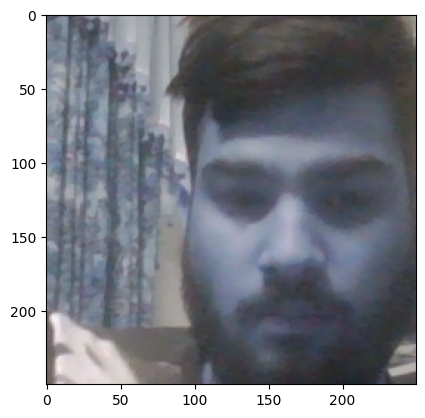

In [17]:
# this is the result from the abv code
plt.imshow(frame)


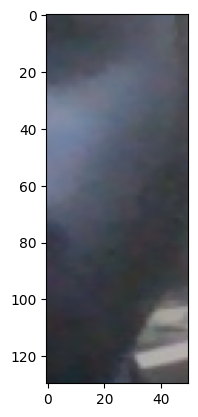

In [18]:
# the input frame size (not 250 x 250) which we need 
frame.shape # -> (480, 640, 3)

#applying slicing over the image to make it 250x250 (the training ds size)
frame[:250, :250 ,:].shape # -> (250, 250, 3)

# plt.imshow(frame[:250, :250 ,:]) # we will get the sliced top-right corner 
plt.imshow(frame[120:120+250,200:200+250 ,:]) # this will center up the slice roughly


### BOOST UP THE MODEL

In [19]:
import uuid

In [20]:
#running 9 copies of anchor image to increase threshold - NOT USED YET 
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6,upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        

        data.append(img)
    return data

In [21]:
# do the pumping of the data set if required - else the model is fit rn (works 80% of the cases)
# did over one image sample 
img_path = os.path.join(ANC_PATH, '8a1cec0e-130f-11ee-bbe6-84a938bd3327.jpg')
img = cv2.imread(img_path)
augmented_image = data_aug(img)

for image in augmented_image:
    # Generate a random UUID for the image name
    image_name = '{}.jpg'.format(uuid.uuid1())
    # Save the image
    cv2.imwrite(os.path.join(ANC_PATH, image_name), image.numpy())

In [22]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_image = data_aug(img)

    for image in augmented_image:
        # Generate a random UUID for the image name
        image_name = '{}.jpg'.format(uuid.uuid1())
        # Save the image
        cv2.imwrite(os.path.join(ANC_PATH, image_name), image.numpy())

KeyboardInterrupt: 

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_image = data_aug(img)

    for image in augmented_image:
        # Generate a random UUID for the image name
        image_name = '{}.jpg'.format(uuid.uuid1())
        # Save the image
        cv2.imwrite(os.path.join(POS_PATH, image_name), image.numpy())

# PreProcessing - Preparing data for deep learning

- ### Get image directories

In [23]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000) # extract everything frome the anchor repo, which has a .jpg extension
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)

In [24]:
dir_test = anchor.as_numpy_iterator()

In [25]:
dir_test.next()

b'data\\anchor\\15cc91c2-18a3-11ee-a5d4-fd56a1c449f3.jpg'

- ### Preprocessing - Scale & Resize 

In [26]:
# loads our image, resize it for us 
def preprocess (file_path): 
    #load up the byte map of the image from the file_path - readin the image
    byte_img = tf.io.read_file(file_path)
    # decodes the image from the byte map 
    img = tf.io.decode_jpeg(byte_img)
    #resizing of the image (preprocessing )
    img = tf.image.resize(img, (100,100))
    # preforming the scalling over the image to be between (0,255) ( preprocessing )
    img = img / 255.0
    return img
# this function will return a numpy equvalent mappingof the image 

In [27]:
img = preprocess('data\\anchor\\86803bca-130f-11ee-955f-84a938bd3327.jpg')

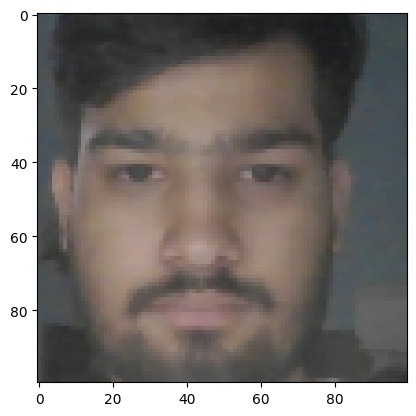

In [28]:
plt.imshow(img)


- ### creating a labelled dataset

In [ ]:
# (anchor , positive) => 1,1,1,1,1,1
# (anchor , negative) => 0,0,0,0,0,0

In [29]:
# anchor_image ( the test image ) , postive_image , 1
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# anchor_image ( the test image ) , negative_image , 0

negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [30]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [31]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [32]:
samples = data.as_numpy_iterator()

In [33]:
eg = samples.next()
eg

(b'data\\anchor\\1b5e77ca-18a3-11ee-9a14-fd56a1c449f3.jpg',
 b'data\\positive\\72cdee1e-18a3-11ee-8d29-fd56a1c449f3.jpg',
 1.0)

- ### Building Train & Train Partition

In [34]:
def preprocess_twin(input_img, validation_img, label ):
    return(preprocess(input_img), preprocess(validation_img), label)

In [35]:
res = preprocess_twin(*eg) # the star destructures the data

In [36]:
# building up dataloader pipeline -  tensorflow pipeline
# running twin data preprocessing over the entire ds
data = data.map(preprocess_twin)
# caching our images
data = data.cache()
#shuffling our images 
data = data.shuffle(buffer_size=10000) #changed from 1024

1.0

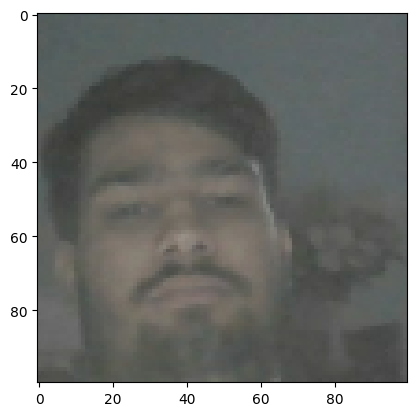

In [37]:
samples = data.as_numpy_iterator()
samp = samples.next()
plt.imshow(samp[1]) # negative / positive image 
samp[2] # labelled 0/1 


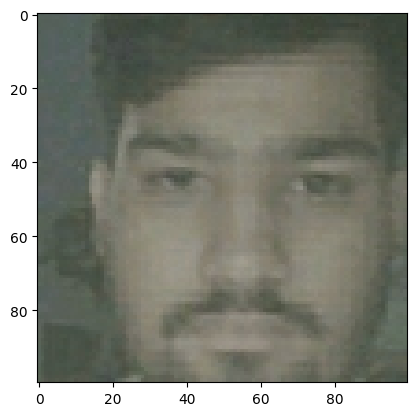

In [38]:
plt.imshow(samp[0]) # paired anchor image

In [39]:
# training & testing partition
# grabbing 70% of the data to train
train_data = data.take(round(len(data)*.7))
# dividing the data into batches of 16
train_data = train_data.batch(16)
# start preprocessing the next set of data over the NN, when we train 
train_data = train_data.prefetch(8)

In [40]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0]) # there are 16 images in the set of each sample set

16

In [41]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [42]:
test_samples = test_data.as_numpy_iterator()
test_sample = test_samples.next()
len(test_sample[0]) # there are 16 images in the set of each sample set

16

## Building a Siamese NN

- ### Build an embedding layer

In [43]:
# this is like a data translator for our NN to verify up the user
# we will be doing convolution  + RelU + max-pooling over the functoin in the image matrix( initially from the input, then over the pooled down image)
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image') # we used keras (tf) here
    # FIRST LAYER 
    #convolution 
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    #max-pooling 
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    #SECOND LAYER
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

    #THIRD LAYER
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

    #FOURTH LAYER (FINAL EMBEDDED LAYER)
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    # fully connected layer with a sigmoid function (flatten + dense layer)
    f1= Flatten()(c4) # flattening the 3 dimensions, to 1 dimension
    d1= Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
    # this will return us the feture vector of 4096 units

In [44]:
inp = Input(shape=(100,100,3))
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_1')>

In [45]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
#max-pooling 
m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

#SECOND LAYER
c2 = Conv2D(128,(7,7),activation='relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
#THIRD LAYER
c3 = Conv2D(128,(4,4),activation='relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
#FOURTH LAYER (FINAL EMBEDDED LAYER)
c4 = Conv2D(256,(4,4),activation='relu')(m3)
# fully connected layer with a sigmoid function (flatten + dense layer)
f1= Flatten()(c4) # flattening the 3 dimensions, to 1 dimension
d1= Dense(4096,activation='sigmoid')(f1)
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [46]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [47]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_4')>

In [48]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       262272    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 128)        0         
 2D)      

- ### create an L1 Distance layer

In [49]:
# L1 distance layer - looks over how similar the images actually are
# will take up the above 4096 feature vector (the embedded model) & output a value 
class L1Dist(Layer):
    def __init__(self,**kwargs): 
        super().__init__() #inheritance
    
    # this is the logic here (the difference b/w the input_embedding and the validation_embedding)
    def call(self,input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [50]:

l1 = L1Dist()
l1

- ### compile the siamese Network/Model

In [51]:
# we make the final model over the embedding and followed by L1Dist, with activation at the end
def make_siamese_model(): 
    # handling the inputs 
    # anchor_image input
    input_img = Input(name='input_img', shape=(100, 100, 3))

    # validation_image input
    validation_img = Input(name='validation_img', shape=(100, 100, 3))

    # combining siamese distance components 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))

    # are those the same person (in the 2 images)
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNetwork')
    

In [52]:
input_image = Input(name='input_img',shape=(100,100,3))
validation_image = Input(name='validation_img',shape=(100,100,3))

embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [53]:
embedding(validation_image)


<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [54]:
siamese_layer= L1Dist()
distances = siamese_layer(embedding(input_image), embedding(validation_image))
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [55]:
classif = Dense(1, activation='sigmoid')(distances)
classif 

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [56]:
model_fin = Model(inputs=[input_image,validation_image], outputs=[classif], name='SiameseNetwork')
model_fin.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [57]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                


                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][0]']         
                                                                                                  
 distance (L1Dist)              (None, 4096)         0           ['embedding[4][0]',              
                                                                  'embedding[5][0]']              
                                                                                                  
 dense_3 (

## Training a Siamese Neural Network

- ### setup a loss function & optimizer

In [58]:
#loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [59]:
#optimizer (adam optimizer) 
opt = tf.keras.optimizers.Adam(1e-4) #0.001 -> Learning rate
# ref -> https://keras.io/api/optimizers/ 

- ### establish Checkpoints

In [60]:
#checkpoints for the model, in order if something breaks down we are able to track as to where the model broke off
checkpoint_dir = './training_checkpointsv2'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

- ### build Train Step Function

In [61]:
test_batch = train_data.as_numpy_iterator()
test_batch.next()

(array([[[[0.36985293, 0.42867646, 0.40465686],
          [0.37279412, 0.4372549 , 0.39656863],
          [0.37058824, 0.43529412, 0.3852941 ],
          ...,
          [0.40098038, 0.4480392 , 0.4343137 ],
          [0.38333333, 0.43039215, 0.422549  ],
          [0.3735294 , 0.42058823, 0.4127451 ]],
 
         [[0.37254903, 0.4345588 , 0.39754903],
          [0.3745098 , 0.4372549 , 0.39411765],
          [0.36544117, 0.43112746, 0.37132353],
          ...,
          [0.39534312, 0.44460785, 0.42671567],
          [0.3870098 , 0.43406862, 0.4227941 ],
          [0.37941176, 0.42647058, 0.41666666]],
 
         [[0.37254903, 0.43529412, 0.39313725],
          [0.37156862, 0.4343137 , 0.38921568],
          [0.36813724, 0.4272059 , 0.36960784],
          ...,
          [0.39240196, 0.4490196 , 0.42230392],
          [0.38921568, 0.4370098 , 0.41911766],
          [0.38627452, 0.43333334, 0.41764706]],
 
         ...,
 
         [[0.37230393, 0.41151962, 0.36838236],
          [0.36960

In [62]:
batch_1 = test_batch.next()

In [63]:
X = batch_1[:2]
Y = batch_1[2]

In [64]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [65]:
Y

array([1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [66]:
#the actual training step for a single loop over the siamese, looped over by the next aspect
# one batch of data (inp_image(100,100,3), & validation_img & the validator -> res value (embed) each-> 4064 to classifier to 1)
# over the abv process we calculate our loss & apply backpropgation over the NN, and get the best possible model
# @tf.function # tf.funnction decorator (compiles a fuinction into a callable TF graph) - we are compiling whatever is happening under this
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [68]:
tf.losses.BinaryCrossentropy

keras.losses.BinaryCrossentropy

- ### create a training Loop

In [69]:
from tensorflow.keras.metrics import Precision, Recall

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #creating a metric object 
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(),r.result().numpy(),p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

- ### train the Model

In [71]:
EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 1s 603ms/step


KeyboardInterrupt: 

## Evaluation of the Model - Making predictions

- ### Import Metrics

In [ ]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

- ### Make Predictions

In [ ]:
# getting a batch from our test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
# make predictions over the model
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 26ms/step


array([[9.9999964e-01],
       [9.7117966e-01],
       [8.0830383e-01],
       [9.9988019e-01],
       [4.3957232e-05],
       [9.9999976e-01],
       [2.7097086e-04],
       [9.9998391e-01],
       [9.9901128e-01],
       [9.9999595e-01],
       [9.9934202e-01],
       [1.0392140e-03],
       [7.4591291e-01],
       [1.0000000e+00],
       [7.9741228e-01],
       [9.9999869e-01]], dtype=float32)

In [ ]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]

In [ ]:
y_true

array([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

- ### Calculating Metrics

In [ ]:
# using the metric to test out the accuracy of the model
m = Recall() # metric object

#calc the recall value
m.update_state(y_true, y_hat)
#return the recall result
m.result().numpy()

1.0

In [ ]:
# using the metric to test out the accuracy of the model
m = Precision() # metric object

#calc the Precision value
m.update_state(y_true, y_hat)
#return the Precision result
m.result().numpy()

1.0

- ### Visualize Our result

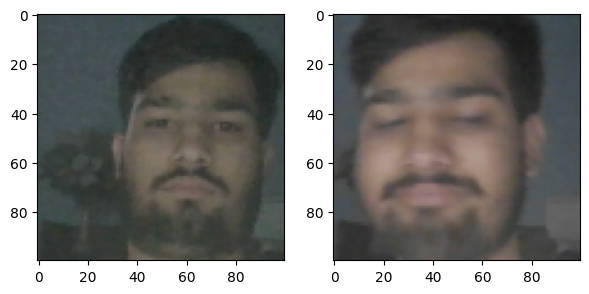

In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
# example of a 1 predicted outcome

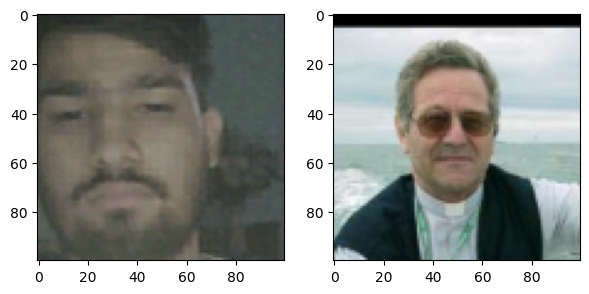

In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(test_input[4])
plt.subplot(1,2,2)
plt.imshow(test_val[4])
# example of a 0 predicted outcome

## Save the Model

In [ ]:
# save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
# reload the model 
model = tf.keras.models.load_model('siamesemodelv2.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
mod_pred_import = model.predict([test_input, test_val])
mod_pred_import

1/1 [==============================] - 0s 93ms/step


array([[9.9999964e-01],
       [9.7117966e-01],
       [8.0830383e-01],
       [9.9988019e-01],
       [4.3957232e-05],
       [9.9999976e-01],
       [2.7097086e-04],
       [9.9998391e-01],
       [9.9901128e-01],
       [9.9999595e-01],
       [9.9934202e-01],
       [1.0392140e-03],
       [7.4591291e-01],
       [1.0000000e+00],
       [7.9741228e-01],
       [9.9999869e-01]], dtype=float32)

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
[1 if prediction_import > 0.5 else 0 for prediction_import in mod_pred_import]

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]

In [ ]:
y_true

array([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

## Real Time Test

- ### Build a verify Function

In [ ]:
# detection_threshold: metric above which a prediction is considered +ve
# verfication_threshold: proportion of +ve predictions/ total +ve samples 
def verify(model, detection_threshold, verification_threshold):
    # buidl results array 
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        # looping through each images in verification folder
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))

        #make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img],axis=1)))
        results.append(result)
    
    # detection_threshold
    detection = np.sum(np.array(results)> detection_threshold)
    # verfication_threshold
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold

    return results, verified


In [ ]:

for image in os.listdir(os.path.join('application_data','verification_images')):
    validation_img = preprocess(os.path.join('application_data','verification_images',image))
    print(validation_img)

tf.Tensor(
[[[0.25710785 0.31593138 0.33553922]
  [0.26764706 0.3245098  0.35392156]
  [0.27058825 0.31862745 0.3627451 ]
  ...
  [0.2252451  0.2615196  0.25955883]
  [0.23137255 0.27058825 0.27450982]
  [0.23137255 0.27058825 0.27107844]]

 [[0.25196078 0.30294117 0.32647058]
  [0.2617647  0.3127451  0.34338236]
  [0.2647059  0.3134804  0.35514706]
  ...
  [0.21078432 0.24387255 0.2531863 ]
  [0.22156863 0.26127452 0.27132353]
  [0.22205882 0.26593137 0.2754902 ]]

 [[0.25857842 0.30367646 0.3272059 ]
  [0.26936275 0.3137255  0.34583333]
  [0.26789215 0.31887254 0.35318628]
  ...
  [0.2009804  0.23406863 0.24338235]
  [0.21176471 0.2529412  0.26960784]
  [0.20784314 0.25882354 0.2882353 ]]

 ...

 [[0.2634804  0.27132353 0.25955883]
  [0.22818628 0.23529412 0.23357843]
  [0.20808823 0.2122549  0.21936275]
  ...
  [0.24166666 0.24166666 0.23970588]
  [0.24313726 0.24313726 0.24117647]
  [0.24387255 0.24387255 0.24191177]]

 [[0.26789215 0.2757353  0.26397058]
  [0.23627451 0.24411765 0

- ### OpenCV real time verification

In [ ]:
# accessing of the web-cam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read() 
    frame = frame[120:120+250,200:200+250 ,:]
    cv2.imshow('verificaion', frame) 
    
    # verfication trigger
    if cv2.waitKey(10) & 0XFF == ord('v'):
        imgname = os.path.join('application_data', 'input_image','input_image.jpg')
        cv2.imwrite(imgname, frame)
        #run verficatoin 
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
        
    if cv2.waitKey(10) & 0XFF == ord('q'): 
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
True
1/1 [==============================] - 0s 17ms/step
True
1/1 [==============================] - 0s 17ms/step
True
1/1 [==============================] - 0s 19ms/step
False


In [ ]:
np.squeeze(results) > 0.8

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])